RANDOM FOREST CLASSIFIER

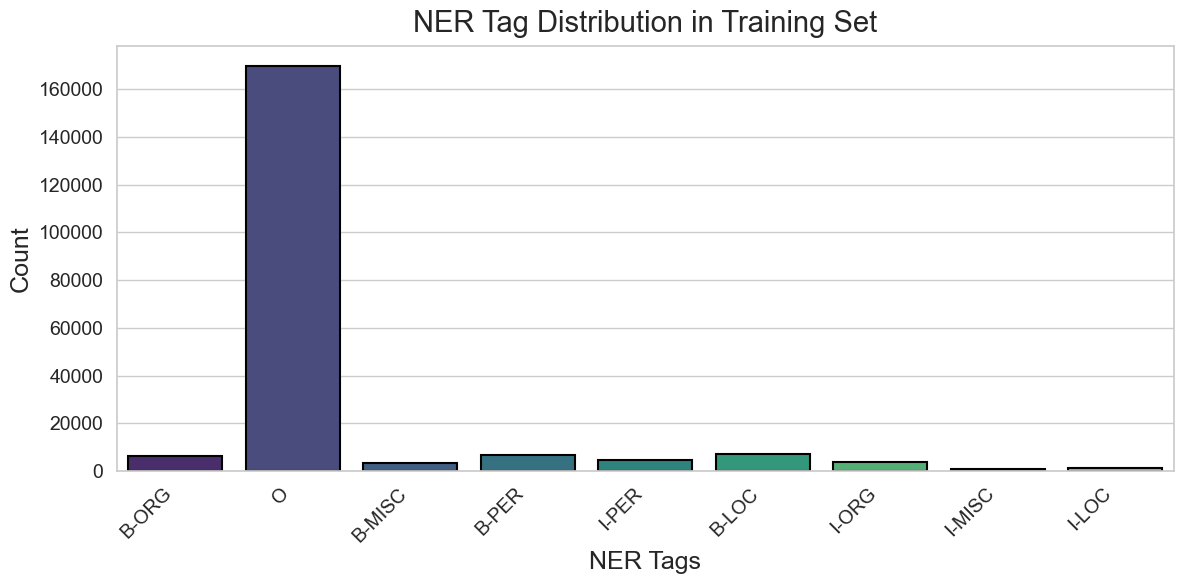

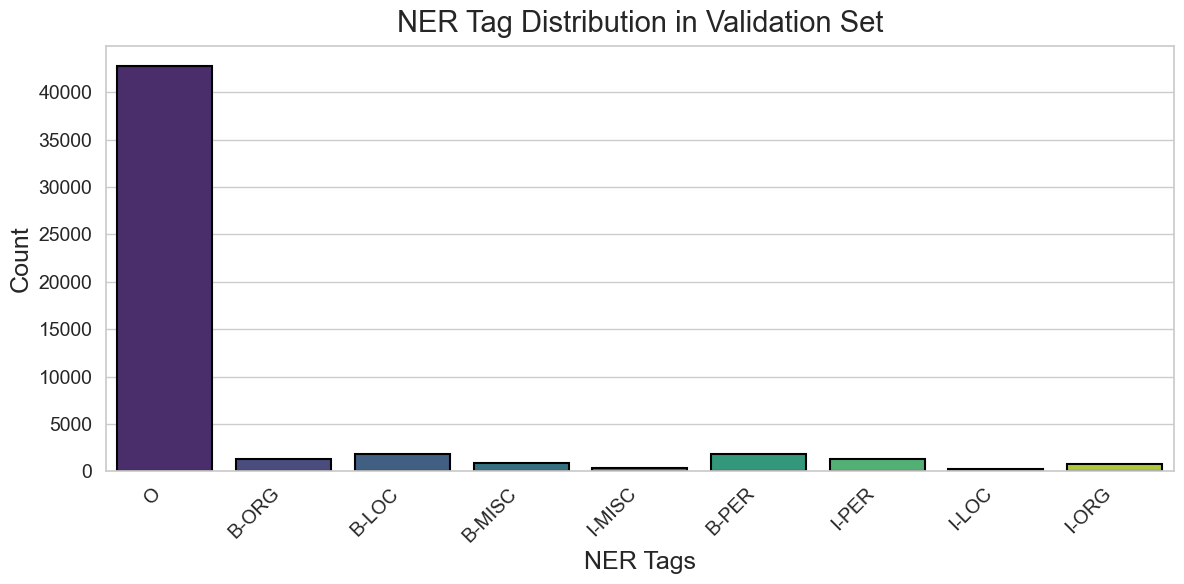

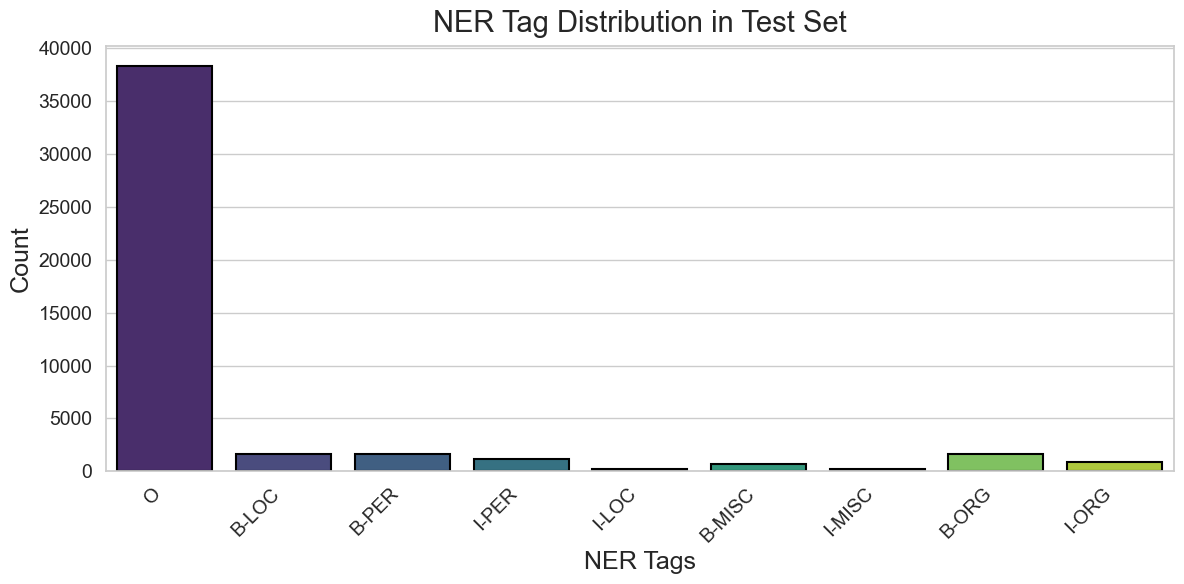

Training Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.47      0.72      0.56      7140
      B-MISC       0.18      0.75      0.29      3438
       B-ORG       0.31      0.62      0.42      6321
       B-PER       0.33      0.59      0.43      6600
       I-LOC       0.66      0.80      0.72      1157
      I-MISC       0.27      0.78      0.40      1155
       I-ORG       0.66      0.56      0.61      3704
       I-PER       0.09      0.93      0.17      4528
           O       0.99      0.59      0.74    169578

    accuracy                           0.61    203621
   macro avg       0.44      0.70      0.48    203621
weighted avg       0.89      0.61      0.69    203621



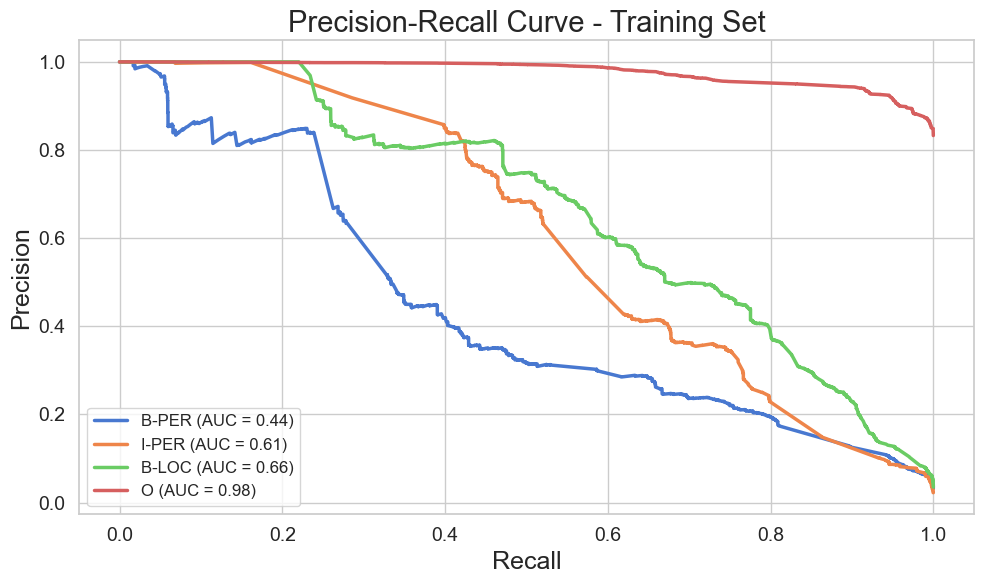

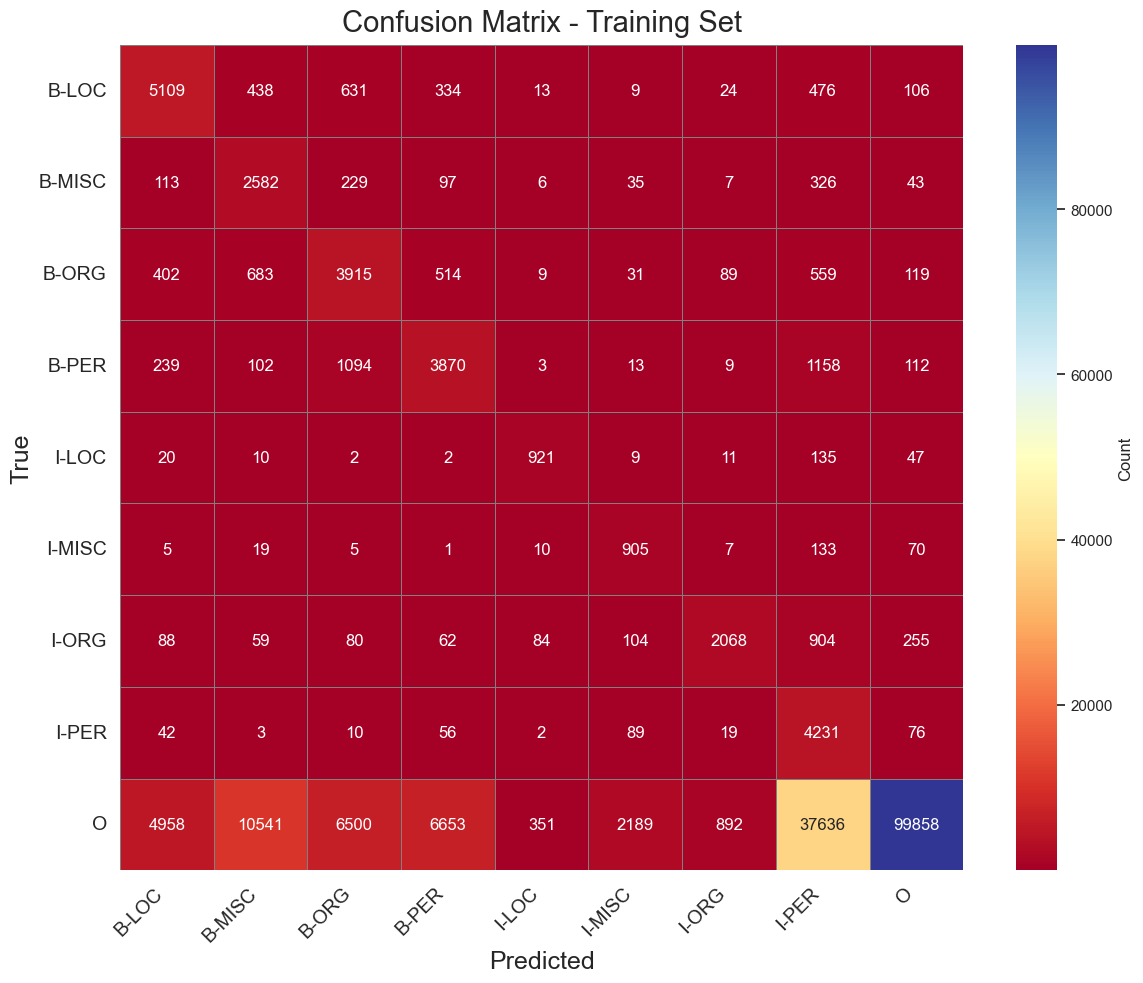

Validation Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.41      0.62      0.50      1837
      B-MISC       0.17      0.69      0.27       922
       B-ORG       0.23      0.50      0.31      1341
       B-PER       0.35      0.58      0.44      1842
       I-LOC       0.52      0.69      0.59       257
      I-MISC       0.21      0.66      0.32       346
       I-ORG       0.48      0.40      0.43       751
       I-PER       0.10      0.89      0.18      1307
           O       0.99      0.58      0.73     42759

    accuracy                           0.59     51362
   macro avg       0.38      0.62      0.42     51362
weighted avg       0.87      0.59      0.67     51362



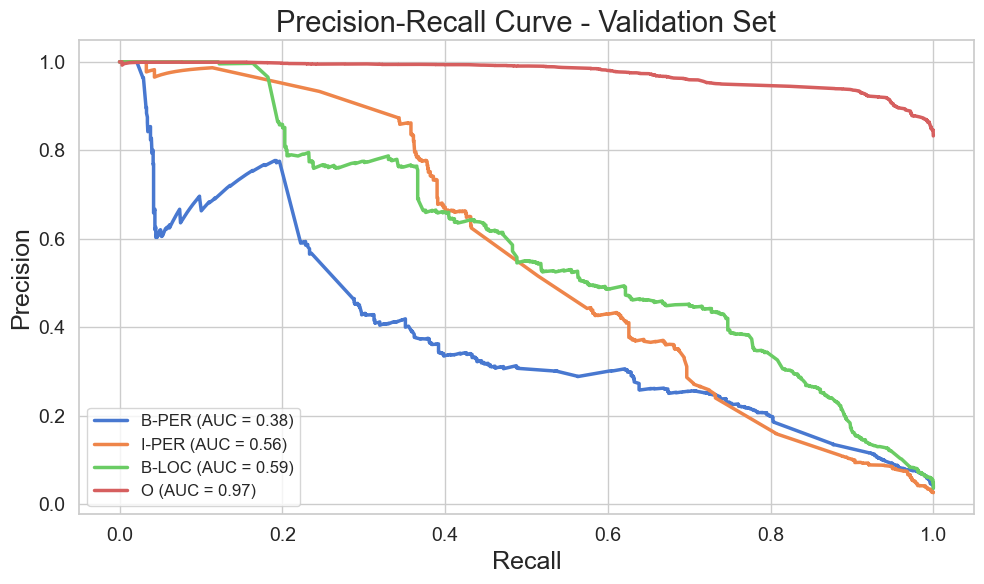

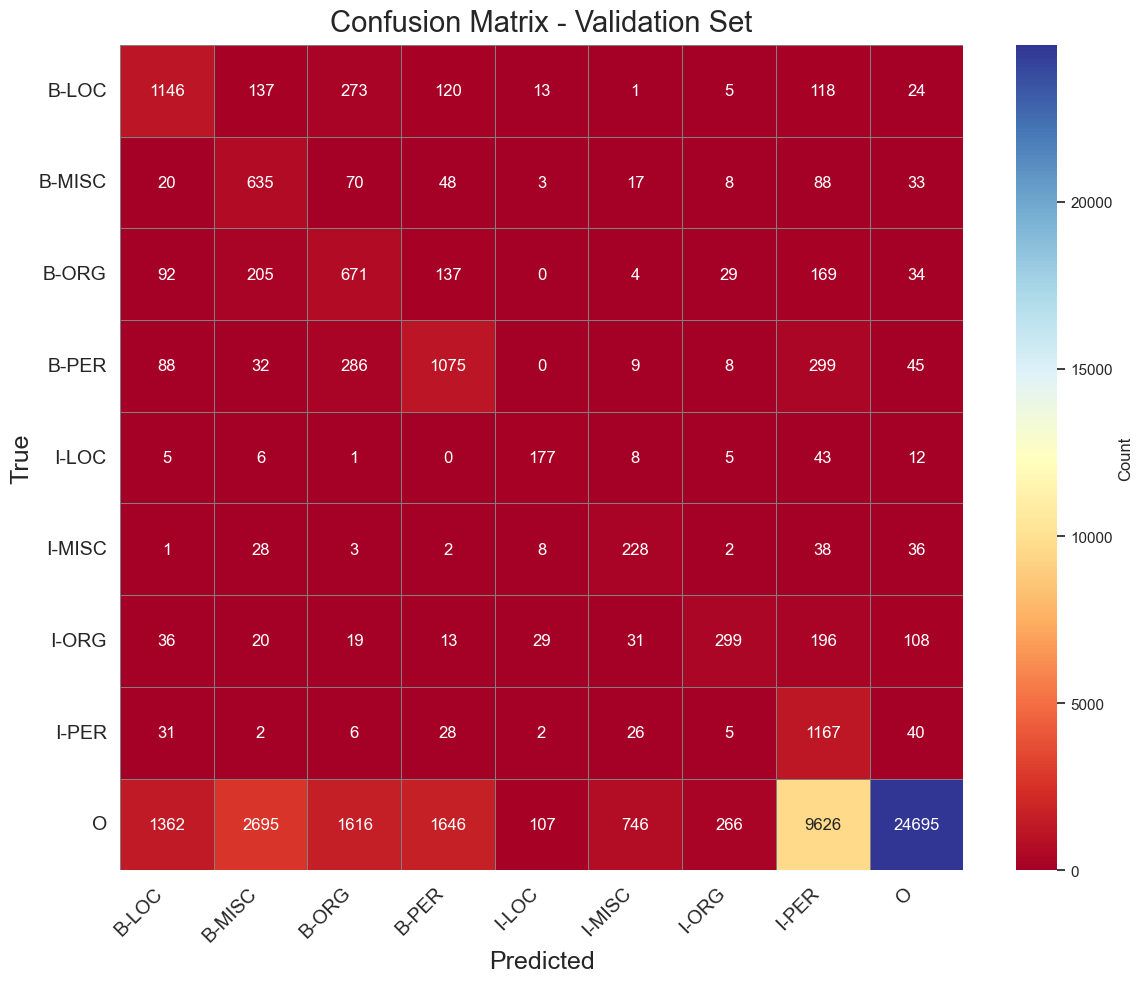

Test Set Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.39      0.56      0.46      1668
      B-MISC       0.15      0.67      0.25       702
       B-ORG       0.29      0.58      0.39      1661
       B-PER       0.34      0.53      0.42      1617
       I-LOC       0.48      0.63      0.55       257
      I-MISC       0.13      0.66      0.22       216
       I-ORG       0.49      0.38      0.43       835
       I-PER       0.10      0.89      0.18      1156
           O       0.99      0.59      0.74     38323

    accuracy                           0.59     46435
   macro avg       0.37      0.61      0.40     46435
weighted avg       0.87      0.59      0.68     46435



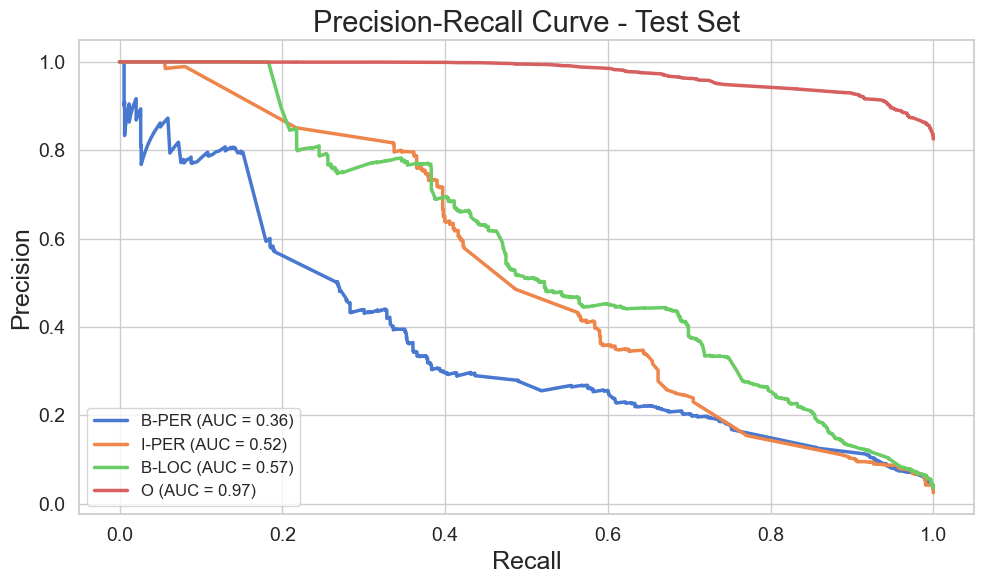

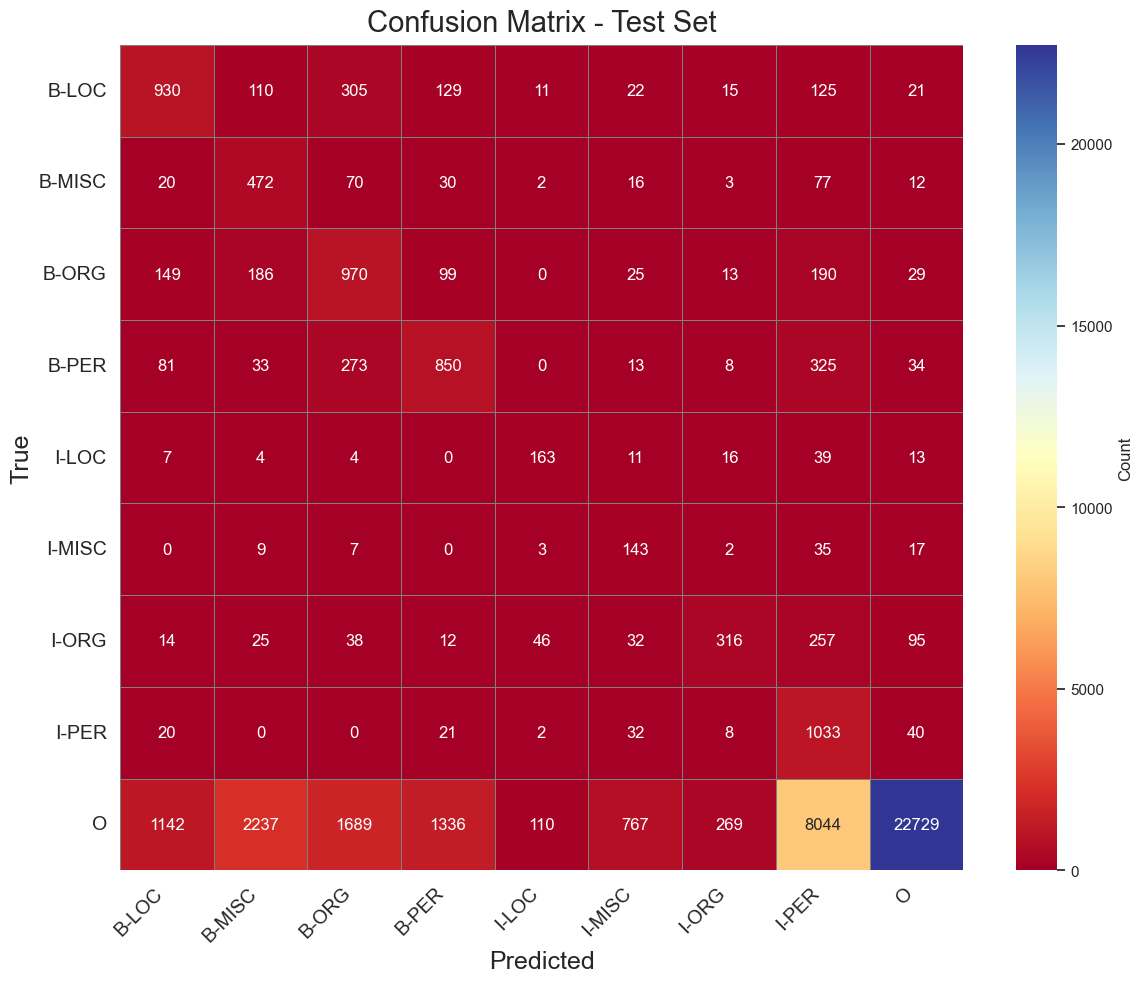

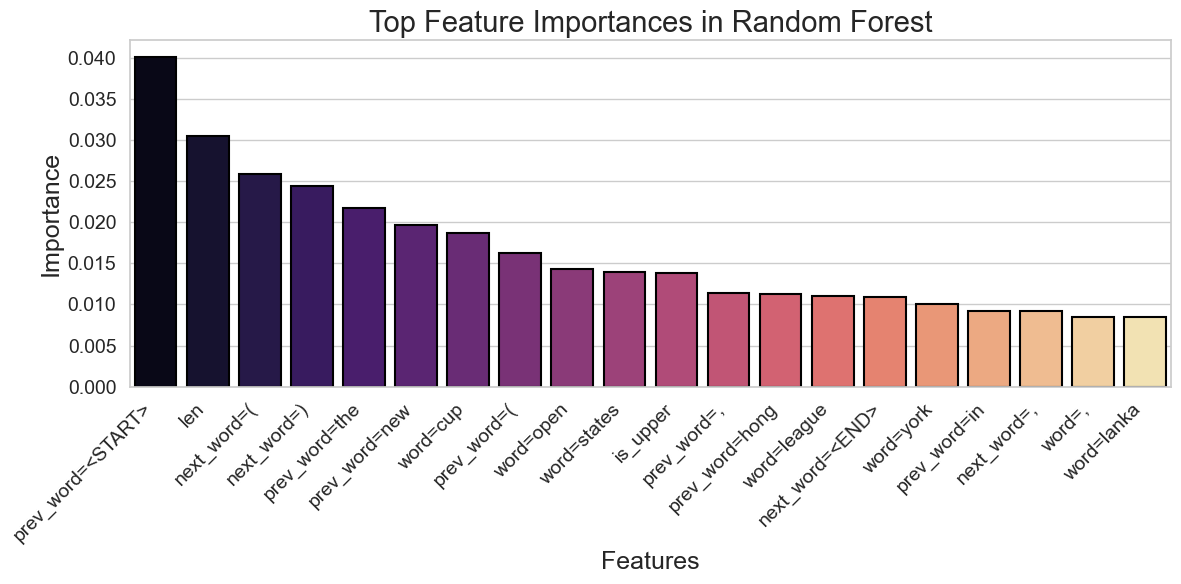

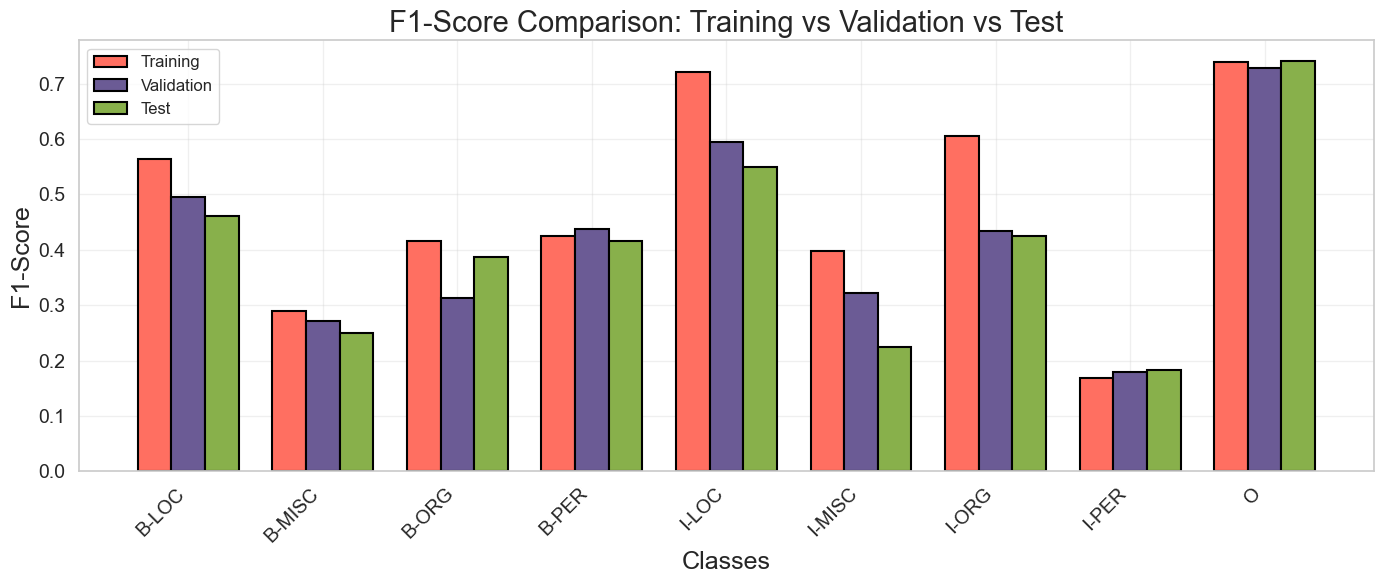

50854

In [23]:
# ## Imports
# Import necessary libraries for data processing, modeling, visualization, and memory management.
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns           # For enhanced visualizations with better aesthetics
import numpy as np              # For numerical operations and array handling
from datasets import load_dataset  # To load the CoNLL-2003 dataset
from sklearn.ensemble import RandomForestClassifier  # Random Forest model for classification
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc  # Evaluation metrics
from sklearn.preprocessing import LabelEncoder  # For encoding string labels to numeric
from sklearn.feature_extraction import DictVectorizer  # For converting feature dictionaries to matrices
from scipy import sparse         # For sparse matrix handling
import gc                       # For garbage collection to manage memory
from collections import Counter # For counting NER tag occurrences
import os                       # For directory handling and file saving

# ## Initial Setup
# Configure Seaborn for consistent and visually appealing plots.
sns.set(style="whitegrid", palette="muted")  # Set white grid background and muted color palette

# Enable garbage collection to manage memory usage.
gc.enable()  # Turn on garbage collection

# ## Plot Directory Setup
# Define a fixed directory for saving all plots.
PLOT_DIR = "plots/randomForest"       # Directory path for Random Forest plots
os.makedirs(PLOT_DIR, exist_ok=True)  # Create directory if it doesn't exist

# ## Step 1: Load CoNLL-2003 Dataset with Streaming
# Load the CoNLL-2003 dataset in streaming mode and extract NER tag names.
conll2003 = load_dataset("conll2003", streaming=True)  # Load dataset with streaming for memory efficiency
label_names = load_dataset("conll2003")["train"].features["ner_tags"].feature.names  # Get NER tag names (e.g., "O", "B-PER")

# ## Step 2: Optimized Data Preparation with Generator
# Define a generator function to stream data from the dataset.
def prepare_data_generator(dataset_split):
    # **Purpose**: Yield data examples one at a time from a dataset split.
    # **Input**: `dataset_split` - A split of the CoNLL-2003 dataset (e.g., "train").
    # **Output**: Yields dictionaries with `words` (tokens) and `tags` (NER labels).
    for example in dataset_split:
        words = example['tokens']  # Extract tokens from the example
        ner_tags = [label_names[tag] for tag in example['ner_tags']]  # Map numeric tags to string names
        yield {'words': words, 'tags': ner_tags}  # Yield dictionary

# ### Enhanced Feature Extraction
# Define a function to extract features from words in a sentence.
def extract_features(words):
    # **Purpose**: Extract features for each word in a sentence for Random Forest classification.
    # **Input**: `words` - List of tokens (sentence).
    # **Output**: List of feature dictionaries for each word.
    features = []
    for i, w in enumerate(words):
        feat = {
            'word': w.lower(),           # Lowercase word
            'len': len(w),               # Length of the word
            'is_upper': w.isupper(),     # Is word all uppercase?
            'is_digit': w.isdigit(),     # Is word a digit?
            'prev_word': words[i-1].lower() if i > 0 else '<START>',  # Previous word or start marker
            'next_word': words[i+1].lower() if i < len(words)-1 else '<END>'  # Next word or end marker
        }
        features.append(feat)  # Add feature dictionary to list
    return features

# ### Process Data in Chunks
# Define a function to process data in chunks using the generator.
def process_data_in_chunks(split_name, chunk_size=1000):
    # **Purpose**: Process dataset split in chunks to manage memory efficiently.
    # **Input**: 
    # - `split_name`: Dataset split (e.g., "train").
    # - `chunk_size`: Number of examples per chunk (default 1000).
    # **Output**: Tuple of `X_feats` (feature lists) and `y` (tag lists).
    X_feats, y = [], []  # Initialize main lists
    generator = prepare_data_generator(conll2003[split_name])  # Create generator for split
    chunk_X, chunk_y = [], []  # Initialize chunk lists
    count = 0  # Chunk counter
    
    for data in generator:
        chunk_X.append(extract_features(data['words']))  # Extract features for words
        chunk_y.append(data['tags'])  # Collect tags
        count += 1  # Increment counter
        
        if count >= chunk_size:  # When chunk size is reached
            X_feats.extend(chunk_X)  # Add chunk to main list
            y.extend(chunk_y)        # Add chunk to main list
            chunk_X, chunk_y = [], []  # Reset chunk lists
            count = 0  # Reset counter
    
    if chunk_X:  # Handle remaining data
        X_feats.extend(chunk_X)  # Add final chunk to main list
        y.extend(chunk_y)        # Add final chunk to main list
    
    return X_feats, y  # Return features and tags

# Prepare datasets for training, validation, and test splits.
X_train_feats, y_train = process_data_in_chunks('train')       # Training data
X_val_feats, y_val = process_data_in_chunks('validation')      # Validation data
X_test_feats, y_test = process_data_in_chunks('test')          # Test data

# ## Step 3: Enhanced NER Distribution Plot
# Define a function to visualize the distribution of NER tags.
def plot_ner_distribution(y_data, title):
    # **Purpose**: Create a bar plot showing the frequency of each NER tag in the dataset.
    # **Input**: 
    # - `y_data`: List of tag lists (NER labels).
    # - `title`: String title for the plot.
    label_counts = Counter(tag for seq in y_data for tag in seq)  # Count occurrences of each tag
    plt.figure(figsize=(12, 6))  # Set figure size to 12x6 inches
    sns.barplot(
        x=list(label_counts.keys()),    # X-axis: Unique NER tags
        y=list(label_counts.values()),  # Y-axis: Counts of each tag
        hue=list(label_counts.keys()),  # Hue for coloring each bar uniquely
        palette="viridis",              # Use Viridis color palette
        legend=False,                   # Disable legend (redundant with x-axis)
        edgecolor="black",              # Bar edge color
        linewidth=1.5                   # Bar edge width
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(fontsize=14)           # Set y-axis tick fontsize
    plt.title(title, fontsize=21, pad=10)  # Set title with increased fontsize
    plt.xlabel("NER Tags", fontsize=18)    # X-axis label with increased fontsize
    plt.ylabel("Count", fontsize=18)       # Y-axis label with increased fontsize
    plt.tight_layout()                     # Adjust layout to prevent clipping
    
    # ### Save Plot
    # Save the plot to the "plots/randomForest" directory with "RandomForest_" prepended.
    file_name = f"RandomForest_{title.replace(' ', '_').replace(':', '')}"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                             # Display the plot
    plt.close()                            # Close the figure to free memory

# Generate NER tag distribution plots for all dataset splits.
plot_ner_distribution(y_train, "NER Tag Distribution in Training Set")    # Training set
plot_ner_distribution(y_val, "NER Tag Distribution in Validation Set")    # Validation set
plot_ner_distribution(y_test, "NER Tag Distribution in Test Set")         # Test set

# ## Step 4: Vectorization
# Convert feature dictionaries to sparse matrices and encode labels.
vectorizer = DictVectorizer(sparse=True)  # Initialize vectorizer for sparse matrices
X_train_flat = [item for sublist in X_train_feats for item in sublist]  # Flatten training features
X_train_vec = vectorizer.fit_transform(X_train_flat)  # Fit and transform training features
del X_train_flat  # Delete flattened list to free memory
gc.collect()      # Trigger garbage collection

X_val_vec = vectorizer.transform([item for sublist in X_val_feats for item in sublist])  # Transform validation features
X_test_vec = vectorizer.transform([item for sublist in X_test_feats for item in sublist])  # Transform test features

# ### Flatten and Encode Labels
# Flatten tag lists and encode them to numeric values.
y_train_flat = [item for sublist in y_train for item in sublist]  # Flatten training tags
y_val_flat = [item for sublist in y_val for item in sublist]      # Flatten validation tags
y_test_flat = [item for sublist in y_test for item in sublist]    # Flatten test tags

label_encoder = LabelEncoder()  # Initialize label encoder
y_train_encoded = label_encoder.fit_transform(y_train_flat)  # Fit and transform training tags
y_val_encoded = label_encoder.transform(y_val_flat)          # Transform validation tags
y_test_encoded = label_encoder.transform(y_test_flat)        # Transform test tags

del y_train_flat, y_val_flat, y_test_flat  # Delete flattened lists to free memory
gc.collect()  # Trigger garbage collection

# ## Step 5: Train Random Forest with Class Weighting
# Initialize and train the Random Forest model.
rf = RandomForestClassifier(
    n_estimators=100,        # Number of trees (100)
    random_state=42,         # Seed for reproducibility
    n_jobs=-1,               # Use all CPU cores
    max_depth=30,            # Maximum tree depth
    min_samples_split=5,     # Minimum samples to split a node
    class_weight='balanced'  # Balance class weights for imbalanced data
)
rf.fit(X_train_vec, y_train_encoded)  # Train the model on vectorized training data

# ## Step 6-9: Evaluation with Confusion Matrix for All Sets
# Define a function to evaluate the Random Forest model and generate plots.
def evaluate_model(X, y_true, split_name, labels):
    # **Purpose**: Evaluate model predictions and visualize performance.
    # **Input**: 
    # - `X`: Vectorized feature matrix.
    # - `y_true`: Encoded true labels.
    # - `split_name`: Name of the dataset split (e.g., "Training Set").
    # - `labels`: List of NER tag names.
    # **Output**: Predictions and classification report.
    y_pred = rf.predict(X)  # Predict labels for input features
    print(f"{split_name} Classification Report:")  # Print header
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=labels,  # Use tag names in report
        zero_division=0,      # Handle division by zero
        output_dict=True      # Return as dictionary
    )
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))  # Print detailed report
    
    # ### Precision-Recall Curve for Key Classes
    # Plot Precision-Recall curves for specific NER tags.
    plt.figure(figsize=(10, 6))  # Set figure size
    for label in ['B-PER', 'I-PER', 'B-LOC', 'O']:  # Key tags to evaluate
        label_idx = label_encoder.transform([label])[0]  # Get numeric label index
        y_true_binary = (y_true == label_idx).astype(int)  # Binary true labels
        y_score = rf.predict_proba(X)[:, label_idx]  # Probability scores for the label
        precision, recall, _ = precision_recall_curve(y_true_binary, y_score)  # Compute PR curve
        pr_auc = auc(recall, precision)  # Calculate area under the curve
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})', linewidth=2.5)  # Plot curve with thick line
    
    plt.xticks(fontsize=14)  # Set x-axis tick fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel('Recall', fontsize=18)  # X-axis label with increased fontsize
    plt.ylabel('Precision', fontsize=18)  # Y-axis label with increased fontsize
    pr_title = f'Precision-Recall Curve - {split_name}'  # Plot title
    plt.title(pr_title, fontsize=21)  # Set title with increased fontsize
    plt.legend(loc='best', fontsize=12)  # Add legend with moderate fontsize
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    
    # ### Save Precision-Recall Plot
    # Save the plot to the "plots/randomForest" directory with "RandomForest_" prepended.
    pr_file_name = f"RandomForest_{pr_title.replace(' ', '_').replace('-', '_')}"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{pr_file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()  # Display plot
    plt.close()  # Close figure
    
    # ### Confusion Matrix
    # Visualize the confusion matrix for predictions vs. true labels.
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))  # Compute confusion matrix
    plt.figure(figsize=(12, 10))  # Set figure size
    sns.heatmap(
        cm, 
        annot=True,              # Show numbers in cells
        fmt='d',                 # Integer format for annotations
        xticklabels=labels,      # X-axis labels (predicted)
        yticklabels=labels,      # Y-axis labels (true)
        cmap='RdYlBu',           # Color map (red-yellow-blue)
        cbar_kws={'label': 'Count'},  # Color bar label
        linewidths=0.5,          # Line width between cells
        linecolor='gray'         # Line color between cells
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(rotation=0, fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel("Predicted", fontsize=18)  # X-axis label with increased fontsize
    plt.ylabel("True", fontsize=18)       # Y-axis label with increased fontsize
    cm_title = f"Confusion Matrix - {split_name}"  # Plot title
    plt.title(cm_title, fontsize=21, pad=10)  # Set title with increased fontsize
    plt.tight_layout()                   # Adjust layout
    
    # ### Save Confusion Matrix Plot
    # Save the plot to the "plots/randomForest" directory with "RandomForest_" prepended.
    cm_file_name = f"RandomForest_{cm_title.replace(' ', '_').replace('-', '_')}"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{cm_file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                           # Display plot
    plt.close()                          # Close figure
    
    return y_pred, report  # Return predictions and report

# Evaluate the model on all dataset splits.
y_train_pred, train_report = evaluate_model(X_train_vec, y_train_encoded, "Training Set", label_encoder.classes_)  # Training set
y_val_pred, val_report = evaluate_model(X_val_vec, y_val_encoded, "Validation Set", label_encoder.classes_)       # Validation set
y_test_pred, test_report = evaluate_model(X_test_vec, y_test_encoded, "Test Set", label_encoder.classes_)         # Test set

# ## Step 10: Feature Importance Plot
# Define a function to visualize the top feature importances in the Random Forest model.
def plot_feature_importance(rf, vectorizer, top_n=20):
    # **Purpose**: Plot the top feature importances from the Random Forest model.
    # **Input**: 
    # - `rf`: Trained Random Forest model.
    # - `vectorizer`: Fitted DictVectorizer.
    # - `top_n`: Number of top features to display (default 20).
    importances = rf.feature_importances_  # Get feature importances
    feature_names = vectorizer.feature_names_  # Get feature names
    indices = np.argsort(importances)[::-1][:top_n]  # Sort indices by importance, take top N
    plt.figure(figsize=(12, 6))  # Set figure size
    sns.barplot(
        x=[feature_names[i] for i in indices],  # X-axis: Top feature names
        y=importances[indices],                 # Y-axis: Importance values
        hue=[feature_names[i] for i in indices],  # Hue for unique colors
        palette="magma",                        # Magma color palette
        legend=False,                           # No legend
        edgecolor="black",                      # Bar edge color
        linewidth=1.5                           # Bar edge width
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    title = "Top Feature Importances in Random Forest"  # Plot title
    plt.title(title, fontsize=21)  # Set title with increased fontsize
    plt.xlabel("Features", fontsize=18)    # X-axis label with increased fontsize
    plt.ylabel("Importance", fontsize=18)  # Y-axis label with increased fontsize
    plt.tight_layout()                     # Adjust layout
    
    # ### Save Plot
    # Save the plot to the "plots/randomForest" directory with "RandomForest_" prepended.
    file_name = f"RandomForest_{title.replace(' ', '_')}"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                             # Display plot
    plt.close()                            # Close figure

# Generate feature importance plot.
plot_feature_importance(rf, vectorizer)

# ## Step 11: F1-Score Comparison Plot
# Define a function to compare F1-scores across dataset splits.
def plot_f1_comparison(train_report, val_report, test_report, title):
    # **Purpose**: Create a bar plot comparing F1-scores for each NER class across splits.
    # **Input**: 
    # - `train_report`, `val_report`, `test_report`: Classification reports from evaluation.
    # - `title`: String title for the plot.
    classes = [c for c in val_report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]  # Filter classes
    train_f1 = [train_report[c]['f1-score'] for c in classes]  # Training F1-scores
    val_f1 = [val_report[c]['f1-score'] for c in classes]      # Validation F1-scores
    test_f1 = [test_report[c]['f1-score'] for c in classes]    # Test F1-scores
    
    x = np.arange(len(classes))  # X-axis positions
    width = 0.25                 # Bar width
    plt.figure(figsize=(14, 6))  # Set figure size
    plt.bar(x - width, train_f1, width, label='Training', color='#FF6F61', edgecolor='black', linewidth=1.5)  # Training bars
    plt.bar(x, val_f1, width, label='Validation', color='#6B5B95', edgecolor='black', linewidth=1.5)          # Validation bars
    plt.bar(x + width, test_f1, width, label='Test', color='#88B04B', edgecolor='black', linewidth=1.5)       # Test bars
    plt.xticks(x, classes, rotation=45, ha='right', fontsize=14)  # Set x-axis labels and fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel('Classes', fontsize=18)                     # X-axis label with increased fontsize
    plt.ylabel('F1-Score', fontsize=18)                    # Y-axis label with increased fontsize
    plt.title(title, fontsize=21)                          # Set title with increased fontsize
    plt.legend(fontsize=12)                                # Add legend with moderate fontsize
    plt.grid(True, alpha=0.3)                              # Add grid with transparency
    plt.tight_layout()                                     # Adjust layout
    
    # ### Save Plot
    # Save the plot to the "plots/randomForest" directory with "RandomForest_" prepended.
    file_name = f"RandomForest_{title.replace(' ', '_').replace(':', '')}"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                                             # Display plot
    plt.close()                                            # Close figure

# Generate F1-score comparison plot.
plot_f1_comparison(train_report, val_report, test_report, "F1-Score Comparison: Training vs Validation vs Test")

# ## Cleanup
# Free memory by deleting large variables and triggering garbage collection.
del X_train_vec, X_val_vec, X_test_vec  # Delete vectorized datasets
gc.collect()                            # Trigger garbage collection

CRF

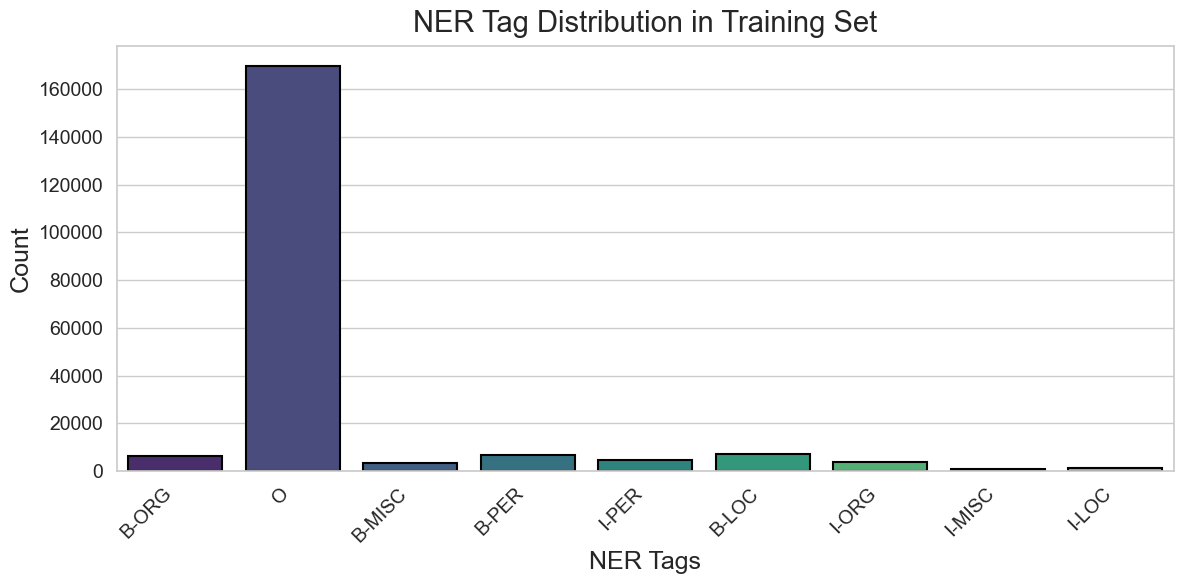

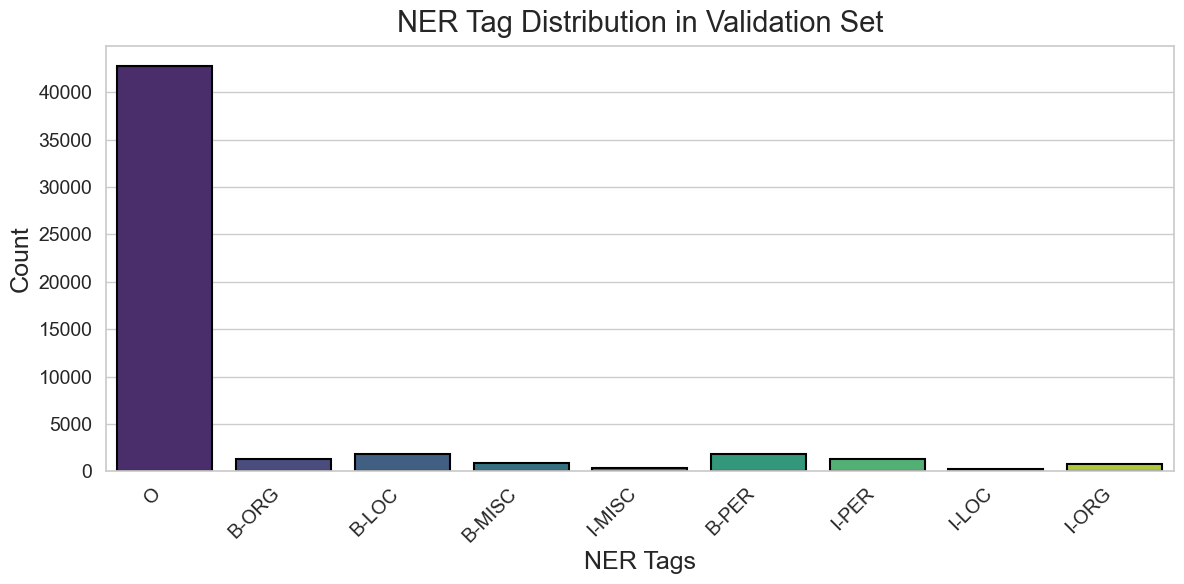

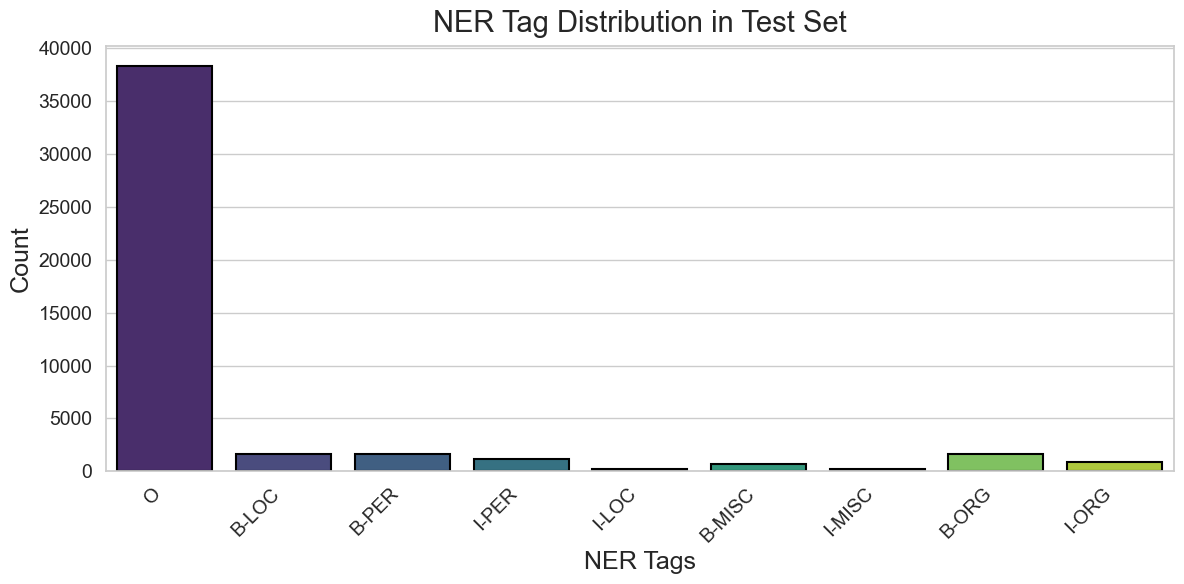

Training Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.99      0.99      0.99      7140
           O       1.00      0.99      0.99      3438
      B-MISC       1.00      0.99      0.99      6321
       B-PER       1.00      1.00      1.00      6600
       I-PER       0.99      0.99      0.99      1157
       B-LOC       0.99      1.00      0.99      1155
       I-ORG       1.00      0.99      1.00      3704
      I-MISC       1.00      1.00      1.00      4528
       I-LOC       1.00      1.00      1.00    169578

    accuracy                           1.00    203621
   macro avg       1.00      0.99      1.00    203621
weighted avg       1.00      1.00      1.00    203621



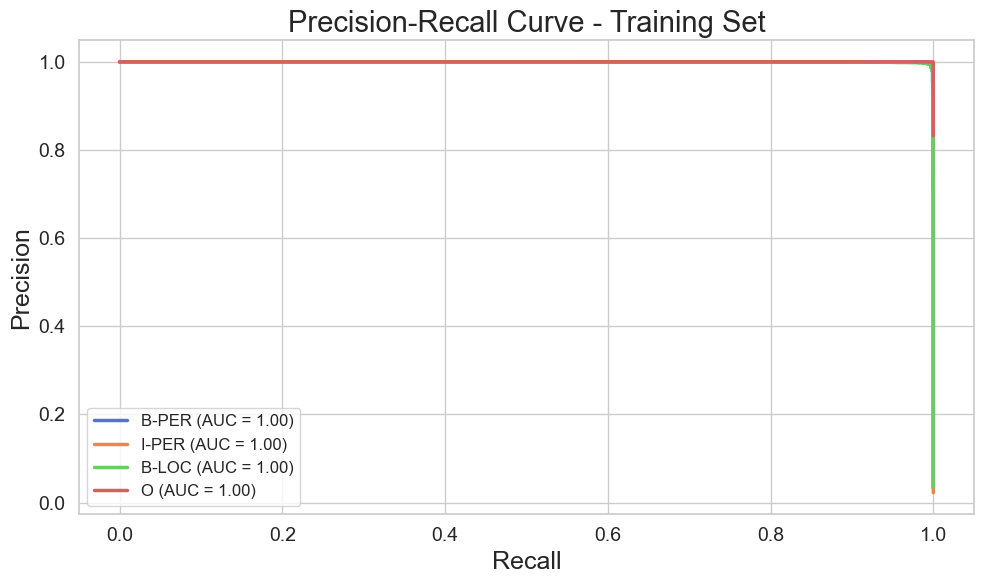

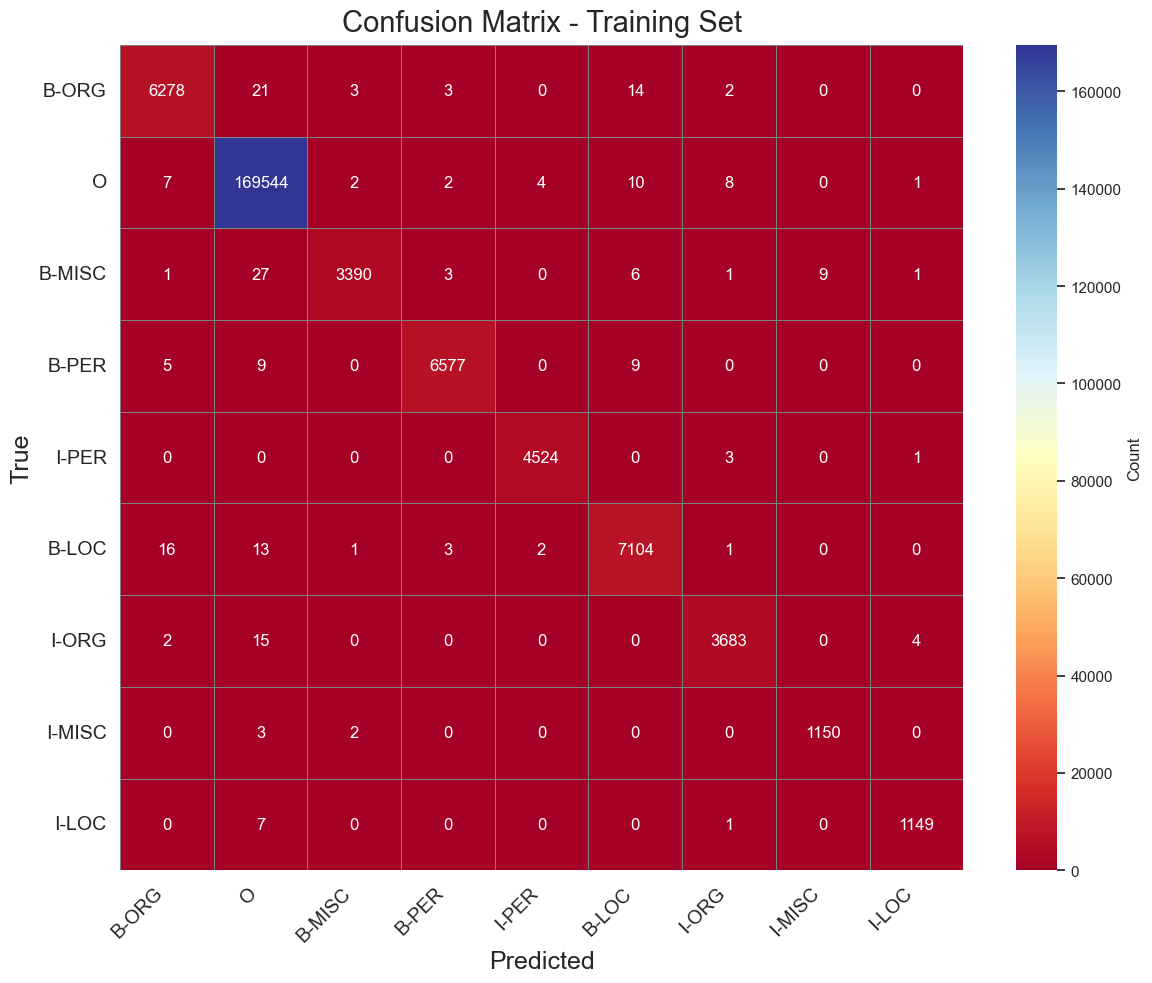

Validation Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.93      0.89      0.91      1837
           O       0.92      0.84      0.88       922
      B-MISC       0.87      0.82      0.84      1341
       B-PER       0.90      0.90      0.90      1842
       I-PER       0.96      0.80      0.87       257
       B-LOC       0.88      0.74      0.80       346
       I-ORG       0.83      0.83      0.83       751
      I-MISC       0.94      0.94      0.94      1307
       I-LOC       0.99      1.00      0.99     42759

    accuracy                           0.98     51362
   macro avg       0.91      0.86      0.89     51362
weighted avg       0.98      0.98      0.98     51362



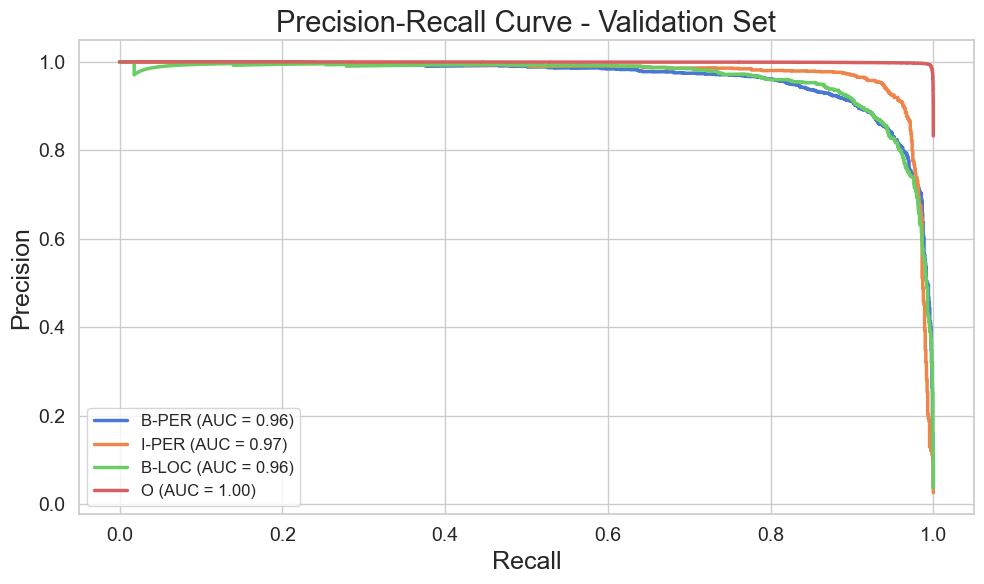

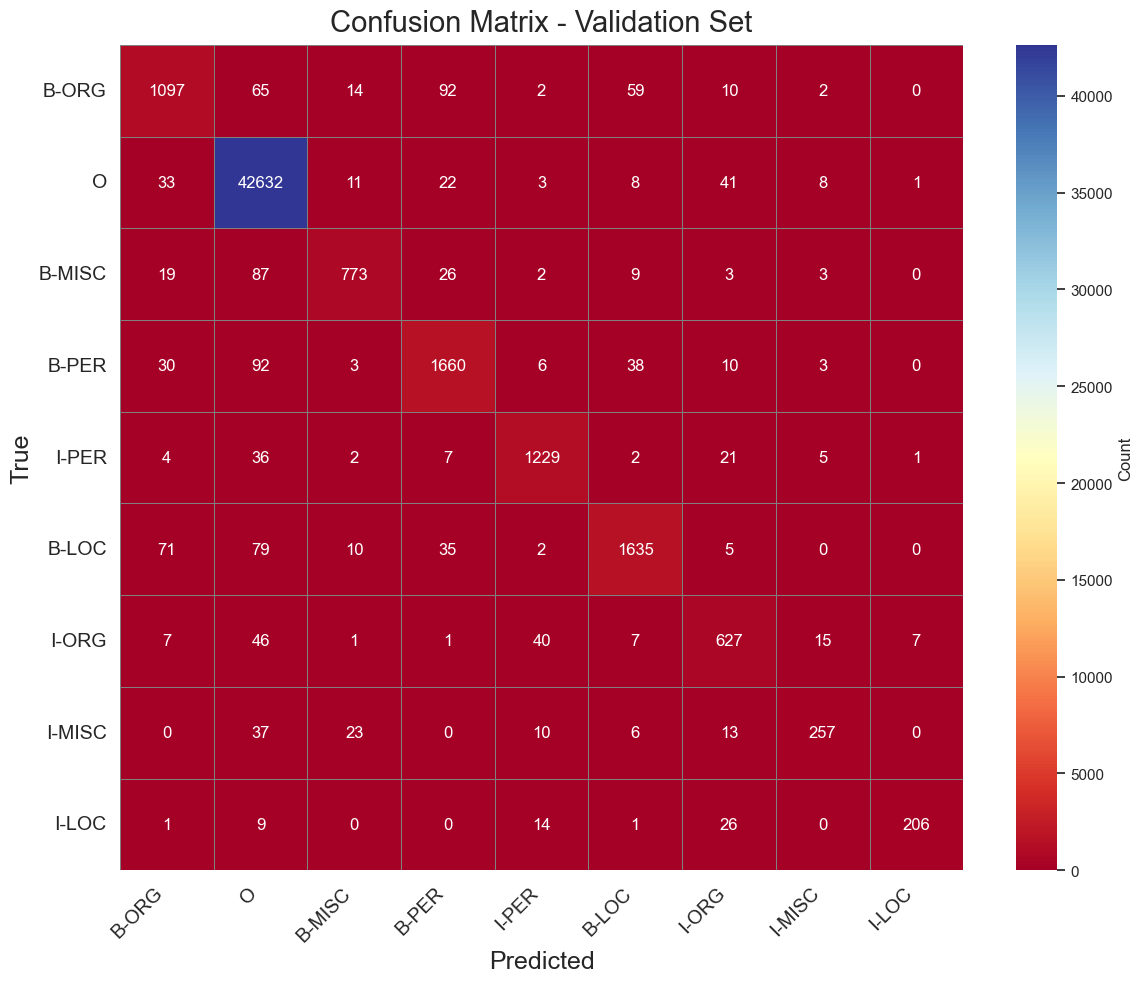

Test Set Classification Report:
              precision    recall  f1-score   support

       B-ORG       0.86      0.83      0.85      1668
           O       0.81      0.76      0.78       702
      B-MISC       0.82      0.71      0.76      1661
       B-PER       0.83      0.84      0.83      1617
       I-PER       0.80      0.72      0.76       257
       B-LOC       0.66      0.64      0.65       216
       I-ORG       0.70      0.74      0.72       835
      I-MISC       0.86      0.96      0.90      1156
       I-LOC       0.99      0.99      0.99     38323

    accuracy                           0.96     46435
   macro avg       0.81      0.80      0.81     46435
weighted avg       0.96      0.96      0.96     46435



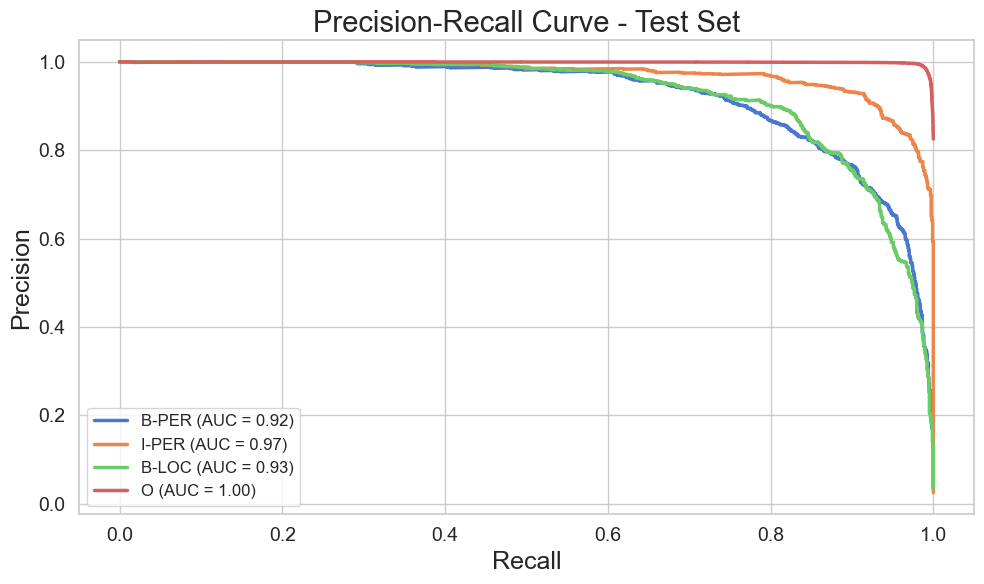

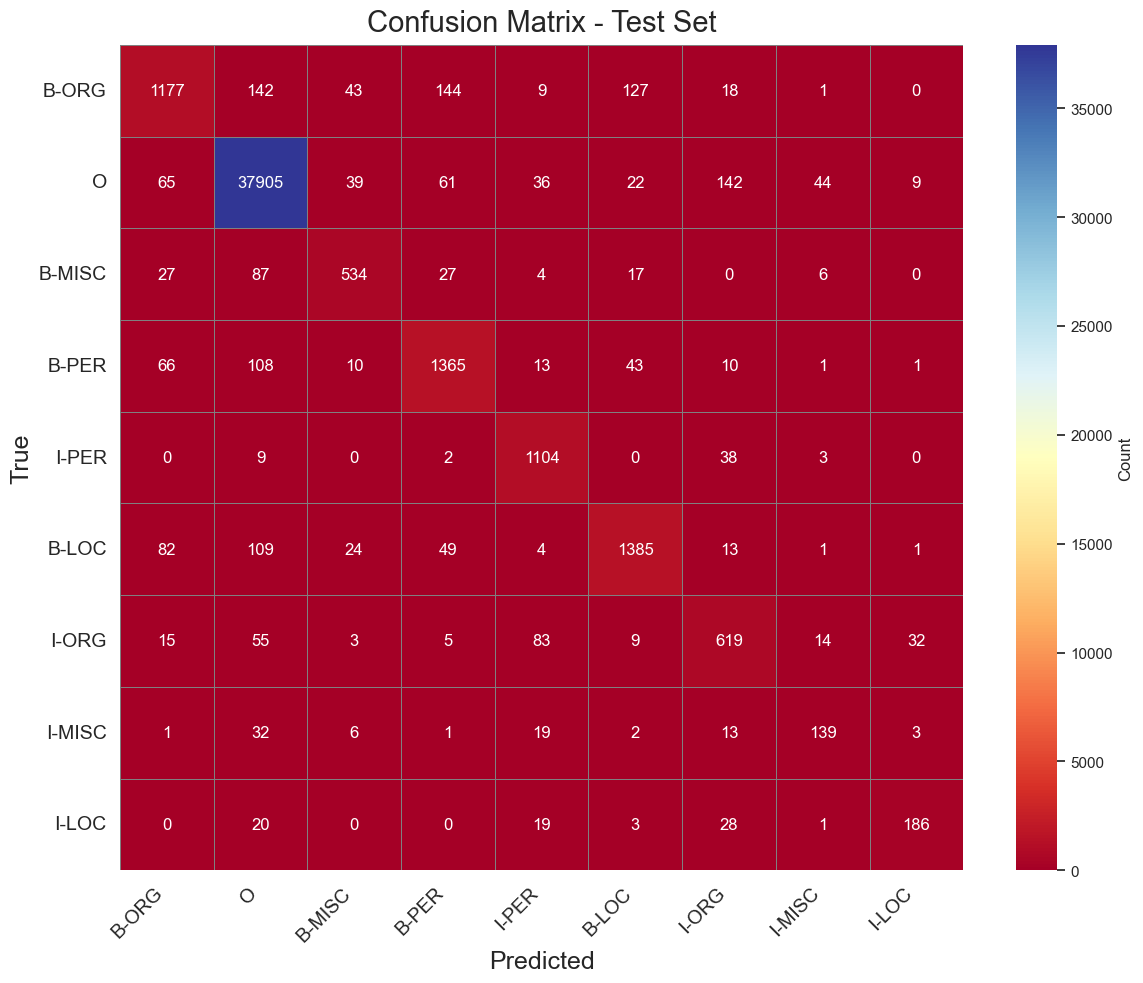

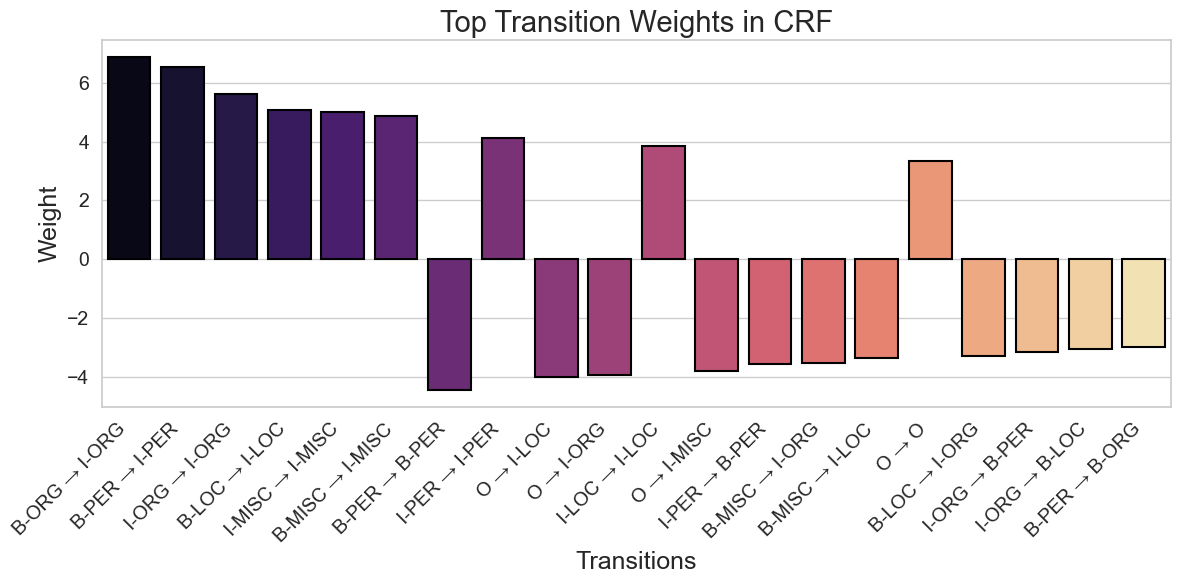

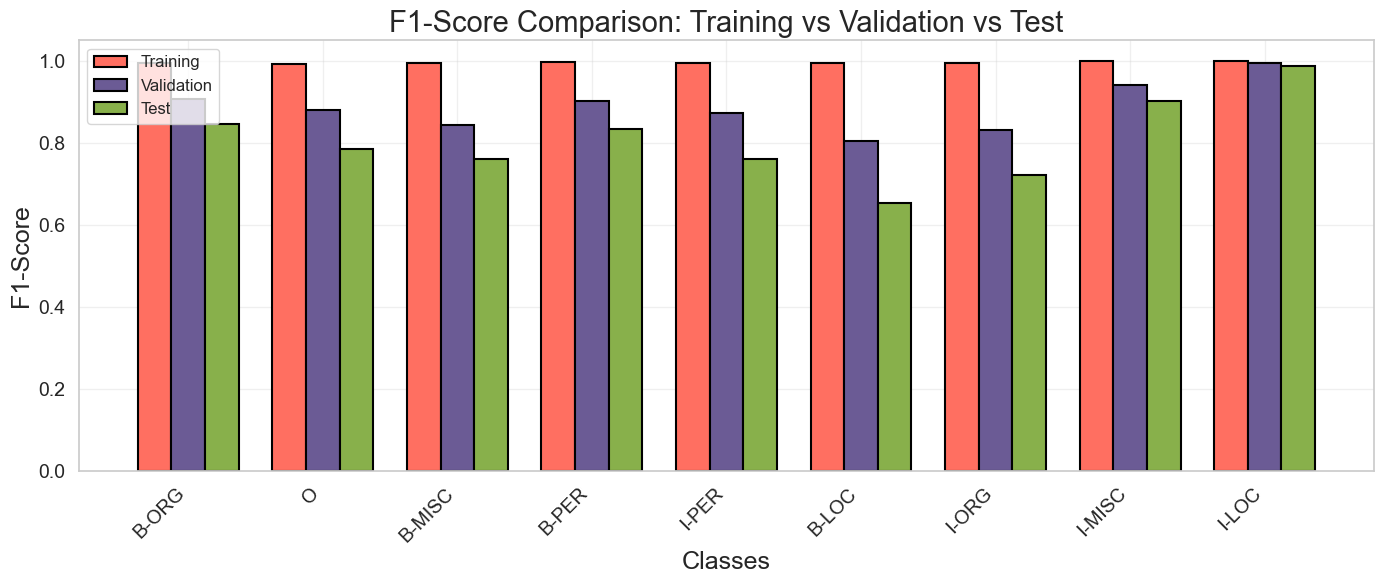

In [22]:
# ## Imports
# Import necessary libraries for data processing, modeling, and visualization.
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns           # For enhanced visualizations with better aesthetics
import numpy as np              # For numerical operations and array handling
from datasets import load_dataset  # To load the CoNLL-2003 dataset
from sklearn_crfsuite import CRF   # Conditional Random Field model for sequence labeling
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc  # Evaluation metrics
from collections import Counter    # For counting NER tag occurrences
import os                          # For directory handling and file saving

# ## Initial Setup
# Configure Seaborn for consistent and visually appealing plots.
sns.set(style="whitegrid", palette="muted")  # Set white grid background and muted color palette

# ## Plot Directory Setup
# Define a fixed directory for saving all plots.
PLOT_DIR = "plots/CRF"              # Directory path for CRF plots
os.makedirs(PLOT_DIR, exist_ok=True)  # Create directory if it doesn't exist

# ## Step 1: Load CoNLL-2003 Dataset
# Load the CoNLL-2003 dataset and extract NER tag names.
conll2003 = load_dataset("conll2003")  # Load dataset without streaming (full load into memory)
label_names = conll2003["train"].features["ner_tags"].feature.names  # Get list of NER tag names (e.g., "O", "B-PER")

# ## Step 2: Prepare Data for CRF
# Define a function to prepare sentences and labels for CRF training.
def prepare_data_for_crf(dataset):
    # **Purpose**: Convert dataset examples into lists of sentences and corresponding NER tags.
    # **Input**: `dataset` - A split of the CoNLL-2003 dataset (e.g., train, validation, test).
    # **Output**: Tuple of `sentences` (list of word lists) and `labels` (list of tag lists).
    sentences, labels = [], []
    for example in dataset:
        words = example['tokens']  # Extract tokens (words) from the example
        ner_tags = [label_names[tag] for tag in example['ner_tags']]  # Map numeric tags to their string names
        sentences.append(words)
        labels.append(ner_tags)
    return sentences, labels

# Prepare training, validation, and test sets for CRF.
X_train, y_train = prepare_data_for_crf(conll2003['train'])       # Training data
X_val, y_val = prepare_data_for_crf(conll2003['validation'])      # Validation data
X_test, y_test = prepare_data_for_crf(conll2003['test'])          # Test data

# ## Step 3: Enhanced NER Tag Distribution Plot
# Define a function to visualize the distribution of NER tags.
def plot_ner_distribution(y_data, title):
    # **Purpose**: Create a bar plot showing the frequency of each NER tag in the dataset.
    # **Input**: 
    # - `y_data`: List of tag lists (NER labels).
    # - `title`: String title for the plot.
    label_counts = Counter(tag for seq in y_data for tag in seq)  # Count occurrences of each tag
    plt.figure(figsize=(12, 6))  # Set figure size to 12x6 inches
    sns.barplot(
        x=list(label_counts.keys()),    # X-axis: Unique NER tags
        y=list(label_counts.values()),  # Y-axis: Counts of each tag
        hue=list(label_counts.keys()),  # Hue for coloring each bar uniquely
        palette="viridis",              # Use Viridis color palette
        legend=False,                   # Disable legend (redundant with x-axis)
        edgecolor="black",              # Bar edge color
        linewidth=1.5                   # Bar edge width
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(fontsize=14)           # Set y-axis tick fontsize
    plt.title(title, fontsize=21, pad=10)  # Set title with increased fontsize
    plt.xlabel("NER Tags", fontsize=18)    # X-axis label with increased fontsize
    plt.ylabel("Count", fontsize=18)       # Y-axis label with increased fontsize
    plt.tight_layout()                     # Adjust layout to prevent clipping
    
    # ### Save Plot
    # Save the plot to the "plots/CRF" directory with "CRF" appended to the file name.
    file_name = f"{title.replace(' ', '_').replace(':', '')}_CRF"  # Create file name from title
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                             # Display the plot
    plt.close()                            # Close the figure to free memory

# Generate NER tag distribution plots for all dataset splits.
plot_ner_distribution(y_train, "NER Tag Distribution in Training Set")    # Training set
plot_ner_distribution(y_val, "NER Tag Distribution in Validation Set")    # Validation set
plot_ner_distribution(y_test, "NER Tag Distribution in Test Set")         # Test set

# ## Step 4: Feature Extraction for CRF
# Define a function to extract features from individual words in a sentence.
def word2features(sent, i):
    # **Purpose**: Extract features for a word at position `i` in a sentence for CRF modeling.
    # **Input**: 
    # - `sent`: List of words (sentence).
    # - `i`: Index of the word to extract features for.
    # **Output**: Dictionary of features for the word.
    word = sent[i]
    features = {
        'bias': 1.0,                # Constant bias term
        'word.lower': word.lower(), # Lowercase word
        'word[-3:]': word[-3:],     # Last 3 characters
        'word[-2:]': word[-2:],     # Last 2 characters
        'word.isupper': word.isupper(),  # Is word all uppercase?
        'word.istitle': word.istitle(),  # Is word title case?
        'word.isdigit': word.isdigit()   # Is word a digit?
    }
    if i > 0:  # If not the first word
        word1 = sent[i-1]
        features.update({
            'prev_word.lower': word1.lower(),    # Previous word lowercase
            'prev_word.istitle': word1.istitle(),  # Previous word title case?
            'prev_word.isupper': word1.isupper()   # Previous word uppercase?
        })
    else:
        features['BOS'] = True  # Beginning of sentence marker
    if i < len(sent)-1:  # If not the last word
        word1 = sent[i+1]
        features.update({
            'next_word.lower': word1.lower(),    # Next word lowercase
            'next_word.istitle': word1.istitle(),  # Next word title case?
            'next_word.isupper': word1.isupper()   # Next word uppercase?
        })
    else:
        features['EOS'] = True  # End of sentence marker
    return features

# Define a function to apply feature extraction to all sentences.
def extract_features(sentences):
    # **Purpose**: Extract features for all words in all sentences.
    # **Input**: `sentences` - List of word lists.
    # **Output**: List of feature lists, one per sentence.
    return [[word2features(sent, i) for i in range(len(sent))] for sent in sentences]

# Extract features for training, validation, and test sets.
X_train_feats = extract_features(X_train)  # Training features
X_val_feats = extract_features(X_val)      # Validation features
X_test_feats = extract_features(X_test)    # Test features

# ## Step 5: Train CRF Model
# Initialize and train the CRF model.
crf = CRF(
    algorithm='lbfgs',             # Use L-BFGS optimization algorithm
    c1=0.1,                        # L1 regularization coefficient
    c2=0.1,                        # L2 regularization coefficient
    max_iterations=100,            # Maximum number of iterations
    all_possible_transitions=True  # Generate all possible state transitions
)
crf.fit(X_train_feats, y_train)  # Train the CRF model on training data

# ## Step 6: Evaluation with All Plots
# Define a function to evaluate the CRF model and generate plots.
def evaluate_model(X, y_true, split_name, labels):
    # **Purpose**: Evaluate CRF predictions and visualize performance.
    # **Input**: 
    # - `X`: List of feature sequences.
    # - `y_true`: List of true tag sequences.
    # - `split_name`: Name of the dataset split (e.g., "Training Set").
    # - `labels`: List of possible NER tags.
    # **Output**: Predictions and classification report.
    y_pred = crf.predict(X)  # Predict tags for input sequences
    y_true_flat = [item for sublist in y_true for item in sublist]  # Flatten true tags
    y_pred_flat = [item for sublist in y_pred for item in sublist]  # Flatten predicted tags
    
    print(f"{split_name} Classification Report:")  # Print header
    report = classification_report(y_true_flat, y_pred_flat, target_names=labels, output_dict=True)  # Generate report as dict
    print(classification_report(y_true_flat, y_pred_flat, target_names=labels))  # Print detailed report
    
    # ### Precision-Recall Curve
    # Plot Precision-Recall curves for key NER tags using marginal probabilities.
    plt.figure(figsize=(10, 6))  # Set figure size
    plotted_curves = False       # Flag to track if any curves are plotted
    for label in ['B-PER', 'I-PER', 'B-LOC', 'O']:  # Key tags to evaluate
        try:
            label_idx = labels.index(label)  # Get index of the label
            y_true_binary = [1 if tag == label else 0 for tag in y_true_flat]  # Binary true labels
            # Flatten marginal probabilities across all sequences
            marginals = [prob[label] for seq in crf.predict_marginals(X) for prob in seq]
            y_score = marginals[:len(y_true_binary)]  # Match length with true labels
            precision, recall, _ = precision_recall_curve(y_true_binary, y_score)  # Compute PR curve
            pr_auc = auc(recall, precision)  # Calculate area under the curve
            plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})', linewidth=2.5)  # Plot curve with thick line
            plotted_curves = True
        except (ValueError, KeyError):
            continue  # Skip if label not found or other error
    plt.xticks(fontsize=14)  # Set x-axis tick fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel('Recall', fontsize=18)  # X-axis label with increased fontsize
    plt.ylabel('Precision', fontsize=18)  # Y-axis label with increased fontsize
    pr_title = f'Precision-Recall Curve - {split_name}'  # Plot title
    plt.title(pr_title, fontsize=21)  # Set title with increased fontsize
    if plotted_curves:
        plt.legend(loc='best', fontsize=12)  # Add legend if curves were plotted
    else:
        plt.text(0.5, 0.5, 'No valid curves plotted', ha='center', va='center', fontsize=12)  # Placeholder text
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    
    # ### Save Precision-Recall Plot
    # Save the plot to the "plots/CRF" directory with "CRF" appended.
    pr_file_name = f"{pr_title.replace(' ', '_').replace('-', '_')}_CRF"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{pr_file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()  # Display plot
    plt.close()  # Close figure
    
    # ### Confusion Matrix
    # Visualize the confusion matrix for predictions vs. true labels.
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)  # Compute confusion matrix
    plt.figure(figsize=(12, 10))  # Set figure size
    sns.heatmap(
        cm, 
        annot=True,              # Show numbers in cells
        fmt='d',                 # Integer format for annotations
        xticklabels=labels,      # X-axis labels (predicted)
        yticklabels=labels,      # Y-axis labels (true)
        cmap='RdYlBu',           # Color map (red-yellow-blue)
        cbar_kws={'label': 'Count'},  # Color bar label
        linewidths=0.5,          # Line width between cells
        linecolor='gray'         # Line color between cells
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(rotation=0, fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel("Predicted", fontsize=18)  # X-axis label with increased fontsize
    plt.ylabel("True", fontsize=18)       # Y-axis label with increased fontsize
    cm_title = f"Confusion Matrix - {split_name}"  # Plot title
    plt.title(cm_title, fontsize=21, pad=10)  # Set title with increased fontsize
    plt.tight_layout()                   # Adjust layout
    
    # ### Save Confusion Matrix Plot
    # Save the plot to the "plots/CRF" directory with "CRF" appended.
    cm_file_name = f"{cm_title.replace(' ', '_').replace('-', '_')}_CRF"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{cm_file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                           # Display plot
    plt.close()                          # Close figure
    
    return y_pred, report  # Return predictions and report

# Evaluate the model on all dataset splits.
y_train_pred, train_report = evaluate_model(X_train_feats, y_train, "Training Set", crf.classes_)  # Training set
y_val_pred, val_report = evaluate_model(X_val_feats, y_val, "Validation Set", crf.classes_)       # Validation set
y_test_pred, test_report = evaluate_model(X_test_feats, y_test, "Test Set", crf.classes_)         # Test set

# ## Step 7: Transition Weights Visualization
# Define a function to visualize the top transition weights in the CRF model.
def plot_transition_weights(crf, top_n=20):
    # **Purpose**: Plot the top transition weights between NER tags in the CRF model.
    # **Input**: 
    # - `crf`: Trained CRF model.
    # - `top_n`: Number of top transitions to display (default 20).
    transitions = crf.transition_features_  # Get transition weights dictionary
    sorted_trans = sorted(transitions.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]  # Sort by absolute weight
    from_labels, to_labels = zip(*[t[0] for t in sorted_trans])  # Extract from/to labels
    weights = [t[1] for t in sorted_trans]  # Extract weights
    
    plt.figure(figsize=(12, 6))  # Set figure size
    sns.barplot(
        x=[f"{f} → {t}" for f, t in zip(from_labels, to_labels)],  # X-axis: Transition labels
        y=weights,                                          # Y-axis: Weights
        hue=[f"{f} → {t}" for f, t in zip(from_labels, to_labels)],  # Hue for unique colors
        palette="magma",                                    # Magma color palette
        legend=False,                                       # No legend
        edgecolor="black",                                  # Bar edge color
        linewidth=1.5                                       # Bar edge width
    )
    plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate x-axis labels, set fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    plt.title("Top Transition Weights in CRF", fontsize=21)  # Set title with increased fontsize
    plt.xlabel("Transitions", fontsize=18)                   # X-axis label with increased fontsize
    plt.ylabel("Weight", fontsize=18)                        # Y-axis label with increased fontsize
    plt.tight_layout()                                       # Adjust layout
    
    # ### Save Plot
    # Save the plot to the "plots/CRF" directory with "CRF" appended.
    file_name = f"Top_Transition_Weights_in_CRF_CRF"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                                               # Display plot
    plt.close()                                              # Close figure

# Generate transition weights plot.
plot_transition_weights(crf)

# ## Step 8: F1-Score Comparison Plot
# Define a function to compare F1-scores across dataset splits.
def plot_f1_comparison(train_report, val_report, test_report, title):
    # **Purpose**: Create a bar plot comparing F1-scores for each NER class across splits.
    # **Input**: 
    # - `train_report`, `val_report`, `test_report`: Classification reports from evaluation.
    # - `title`: String title for the plot.
    classes = [c for c in val_report.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]  # Filter classes
    train_f1 = [train_report[c]['f1-score'] for c in classes]  # Training F1-scores
    val_f1 = [val_report[c]['f1-score'] for c in classes]      # Validation F1-scores
    test_f1 = [test_report[c]['f1-score'] for c in classes]    # Test F1-scores
    
    x = np.arange(len(classes))  # X-axis positions
    width = 0.25                 # Bar width
    plt.figure(figsize=(14, 6))  # Set figure size
    plt.bar(x - width, train_f1, width, label='Training', color='#FF6F61', edgecolor='black', linewidth=1.5)  # Training bars
    plt.bar(x, val_f1, width, label='Validation', color='#6B5B95', edgecolor='black', linewidth=1.5)          # Validation bars
    plt.bar(x + width, test_f1, width, label='Test', color='#88B04B', edgecolor='black', linewidth=1.5)       # Test bars
    plt.xticks(x, classes, rotation=45, ha='right', fontsize=14)  # Set x-axis labels and fontsize
    plt.yticks(fontsize=14)  # Set y-axis tick fontsize
    plt.xlabel('Classes', fontsize=18)                     # X-axis label with increased fontsize
    plt.ylabel('F1-Score', fontsize=18)                    # Y-axis label with increased fontsize
    plt.title(title, fontsize=21)                          # Set title with increased fontsize
    plt.legend(fontsize=12)                                # Add legend with moderate fontsize
    plt.grid(True, alpha=0.3)                              # Add grid with transparency
    plt.tight_layout()                                     # Adjust layout
    
    # ### Save Plot
    # Save the plot to the "plots/CRF" directory with "CRF" appended.
    file_name = f"{title.replace(' ', '_').replace(':', '')}_CRF"  # Create file name
    plt.savefig(f"{PLOT_DIR}/{file_name}.png", dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()                                             # Display plot
    plt.close()                                            # Close figure

# Generate F1-score comparison plot.
plot_f1_comparison(train_report, val_report, test_report, "F1-Score Comparison: Training vs Validation vs Test")